<a href="https://colab.research.google.com/github/mariamahmed2/min_max_multi_objective_cyber_security_optimisation/blob/main/min_max_multi_objective_cyber_security_optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cvxpy as cp
import numpy as np
#from ortools.linear_solver import pywraplp

# Attack Graph

A probabilistic attack graph \( G = (V, E, h, t, p, s, T) \) is defined as follows:

- **V**: Set of vertices (nodes), each representing an attacker’s privilege state.
- **E**: Multi-set of directed edges, where each edge \( e \) is represented by an ordered triplet \( e = (i, j, k) \). \( i \) and \( j \) are the tail and head vertices of the edge, and \( k \) is its index.
- **h**: A function \( h: E \rightarrow V \) returning the head vertex of an edge.
- **t**: A function \( t: E \rightarrow V \) returning the tail vertex of an edge.
- **p**: A function \( p: E \rightarrow (0,1] \) representing the conditional success probability of the attack step corresponding to an edge.
- **s**: A designated source vertex indicating the initial privilege state of the attacker.
- **T**: A subset of vertices labelled as target nodes (or sink vertices) representing the potential goals of an attacker.

## Attack Path and Success Probability

An attack path \( \omega_{s \rightarrow t} \) from source \( s \) to target \( t \) is a sequence of directed edges \( (e_1, e_2, \ldots, e_j) \) where:

- \( t(e_1) = s \)
- \( h(e_i) = t(e_{i+1}) \)
- \( h(e_j) = t \)

The success probability of an attack path \( \omega_{s \rightarrow t} \) is the product of the success probabilities of the edges in the path:
\[ P(\omega_{s \rightarrow t}) = \prod_{e \in \omega_{s \rightarrow t}} p(e) \]

## Security Risk Measure

The overall security risk \( R \) is defined as the highest success probability of any attack path from the source to the target. This measure focuses on the most effective (i.e., most likely to succeed) attack path:
\[ R = \max_{\omega_{s \rightarrow t}} \prod_{e \in \omega_{s \rightarrow t}} p(e) \]

This optimization problem, referred to as the Attack problem, aims to identify the attack path with the maximum success probability.

## Mathematical Formulation of the Attack Problem

The Attack problem is formalized as:
\[ R := \max_{\omega_{s \rightarrow t}} \prod_{e \in \omega_{s \rightarrow t}} p(e) \]

where the optimization is over all possible paths from the source node \( s \) to the target node \( t \).

## Considerations

- **Probabilistic Independence**: The model assumes that the success probabilities of attack steps are independent.


#Attack Problrm
\begin{align*}
\max_{y \in \mathbb{R}^{|E|}} &\quad \sum_{e \in E} y_e \log(p_e) \\
\text{subject to:} &\quad y_e \geq 0, \quad \forall e \in E, \\
&\quad \sum_{e: h(e) = i} y_e - \sum_{e: t(e) = i} y_e =
\begin{cases}
1, & \text{if } i = s, \\
-1, & \text{if } i = t, \\
0, & \text{otherwise},
\end{cases}
\end{align*}


In [ ]:
class AttackGraph:

  def __init__(self):
    self.V = set()  # Set of vertices (nodes), each representing an attacker’s privilege state
    self.E = {}     # Dictionary of edges Key: (tail, head), Value: list of edge indices
    self.h = {}     # Function to get the head vertex of an edge
    self.t = {}     # Function to get the tail vertex of an edge
    self.p = {}     # Dictionary to store success probability for each edge
    #self.C = {}     # Dictionary to store cost of each control at each level (c, l)
    #self.I = {}     # Dictionary to store indirect cost of each control at each level (c, l)
    self.s = None   # Source vertex
    self.T = set()  # Set of target vertices

  def add_vertex(self, v):
    self.V.add(v)

  def add_edge(self, tail, head, success_probability, index=0):
    """
    Adds a directed edge between two vertices with a success probability
    - tail: Source vertex
    - head: Destination vertex
    - success_probability: Conditional success probability
    - index: Index for edges between the same tail and head
    """
    key = (tail, head)
    if key not in self.E:
      self.E[key] = []
    self.E[key].append(index)
    self.h[(tail, head, index)] = head
    self.t[(tail, head, index)] = tail
    self.p[index] = success_probability

  def set_source(self, v):
    self.s = v

  def add_target(self, v):
    self.T.add(v)

  def solve_attack_problem(self):

        E = len(self.p)
        y = cp.Variable(E, boolean=True)
        objective = cp.Maximize(cp.sum([y[i] * np.log(self.p[i]) for i in range(E)]))
        constraints = []

        for node in self.V:
            if node == self.s:
                constraints.append(cp.sum([y[i] for (tail, head), indices in self.E.items() for i in indices if tail == node]) -
                                   cp.sum([y[i] for (tail, head), indices in self.E.items() for i in indices if head == node]) == 1)
            elif node in self.T:
                constraints.append(cp.sum([y[i] for (tail, head), indices in self.E.items() for i in indices if tail == node]) -
                                   cp.sum([y[i] for (tail, head), indices in self.E.items() for i in indices if head == node]) == -1)
            else:
                constraints.append(cp.sum([y[i] for (tail, head), indices in self.E.items() for i in indices if tail == node]) -
                                   cp.sum([y[i] for (tail, head), indices in self.E.items() for i in indices if head == node]) == 0)

        prob = cp.Problem(objective, constraints)
        prob.solve()
        return y.value, prob.value




In [ ]:
if __name__ == "__main__":
    graph = AttackGraph()

    # Add vertices
    for v in range(6):
        graph.add_vertex(v)

    # Add edges:   def add_edge(self, tail, head, success_probability, index=0):
    graph.add_edge(0, 1, 0.9, index=0)
    graph.add_edge(1, 2, 0.8, index=1)
    graph.add_edge(0, 3, 0.7, index=2)
    graph.add_edge(3, 4, 0.6, index=3)
    graph.add_edge(4, 2, 0.5, index=4)
    graph.add_edge(1, 4, 0.4, index=5)
    graph.add_edge(4, 5, 0.3, index=6)
    graph.add_edge(5, 2, 0.2, index=7)

    # Set source and target vertices
    graph.set_source(1)
    graph.add_target(4)



    # Solve attack problem
    y_attack, attack_value = graph.solve_attack_problem()
    print(f"Attack Problem Solution: {y_attack}, Maximum Log Probability: {attack_value}")





Attack Problem Solution: [0. 0. 0. 0. 0. 1. 0. 0.], Maximum Log Probability: -0.916290731874155


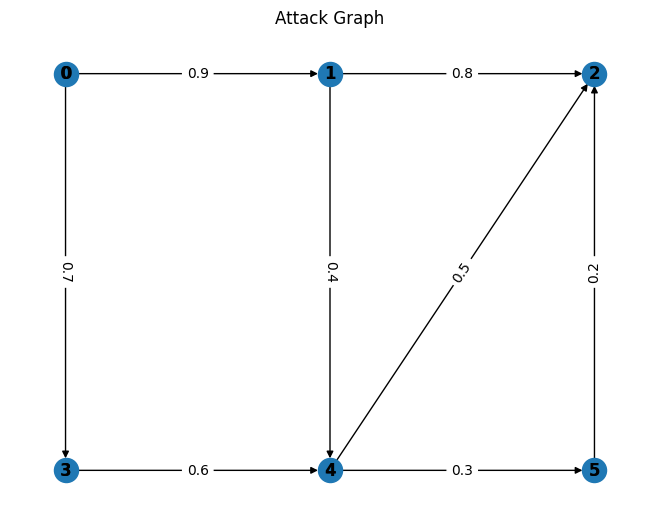

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from([0, 1, 2, 3, 4, 5])

# Add edges with weights (success probabilities) as labels
G.add_edge(0, 1, weight=0.9)
G.add_edge(1, 2, weight=0.8)
G.add_edge(0, 3, weight=0.7)
G.add_edge(3, 4, weight=0.6)
G.add_edge(4, 2, weight=0.5)
G.add_edge(1, 4, weight=0.4)
G.add_edge(4, 5, weight=0.3)
G.add_edge(5, 2, weight=0.2)

# Optional: Set node positions for layout
pos = {
    0: (1, 2),
    1: (2, 2),
    2: (3, 2),
    3: (1, 1),
    4: (2, 1),
    5: (3, 1),
}

# Draw the graph with labels
nx.draw(G, pos, with_labels=True, font_weight='bold')
nx.draw_networkx_labels(G, pos, font_size=12)

# Add edge weights as labels near the edges
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Customize plot
plt.title("Attack Graph")
plt.axis('off')
plt.show()


# Cyber-Security Optimization Problem

## Problem Representation

The code represents a cyber-security optimization problem based on a simplified version of the methodology described in the paper. The goal is to minimize the overall security risk by selecting appropriate security controls while considering budget constraints. The security controls can be applied to various edges in an attack graph, and each control can reduce the probability of a successful attack.

## Attack Graph

The attack graph is defined using NetworkX and consists of nodes and edges:
- **Nodes**: Represent different states or stages in an attack.
- **Edges**: Represent potential attack paths between these states. Each edge has an associated success probability, which can be mitigated by applying security controls.

## Variables

1. **Binary Variables for Control Implementations (`x`)**:
   - $x_{cl}$: A binary variable indicating whether control $c$ is implemented at level $l$.

2. **Binary Variables for Edges (`y`)**:
   - $y_e$: A binary variable indicating whether edge $e$ is part of the optimal attack path.

3. **Dual Variables for Flow Conservation ($\lambda_s$ and $\lambda_t$)**:
   - $\lambda_s$: Dual variable for the source node.
   - $\lambda_t$: Dual variable for the target node.

## Objective Function

The objective function is to minimize the maximum success probability of an attack path, considering the effects of the security controls:

$$\text{Minimize} \quad \lambda_t - \lambda_s $$

Where:
- $\lambda_t$ and $\lambda_s$ are the dual variables for the target and source nodes, respectively.
- $\log(p_{cl})$ represents the logarithm of the success probability of attack paths when control $c$ is implemented at level $l$.

## Constraints

1. **Flow Conservation Constraints**:
   - For the source node:
     $$\sum_{e \text{ exiting } v} y_e - \sum_{e \text{ entering } v} y_e = 1$$
   - For the target node:
     $$\sum_{e \text{ exiting } v} y_e - \sum_{e \text{ entering } v} y_e = -1$$
   - For intermediate nodes:
     $$\sum_{e \text{ exiting } v} y_e - \sum_{e \text{ entering } v} y_e = 0$$

2. **Control Implementation Constraints**:
   - Ensure only one level of each control can be implemented:
     $$\sum_{l \in \text{levels}} x_{cl} \leq 1 \quad \forall c$$

3. **Cost Constraints**:
   - Total direct cost should not exceed the budget $B_D$:
     $$\sum_{c \in \text{controls}} \sum_{l \in \text{levels}} \text{cost}_{cl} x_{cl} \leq B_D$$
   - Total indirect cost should not exceed the budget $B_I$:
     $$\sum_{c \in \text{controls}} \sum_{l \in \text{levels}} \text{indirect cost}_{cl} x_{cl} \leq B_I$$

4. **Logarithmic Constraints for Success Probabilities on Edges**:
   - Ensure the logarithmic transformation of success probabilities and the effects of controls are correctly represented:
     $$\lambda_t - \lambda_s \geq \log(\pi_e) + \sum_{c \in \text{controls}} \sum_{l \in \text{levels}} x_{cl} \log(p_{cl}) \quad \forall e$$




In [ ]:
!pip install cvxpy numpy networkx
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 16.8 MB/s eta 0:00:00


## Example 1

### Define the Attack Graph and Controls

In [ ]:
import cvxpy as cp
import numpy as np
import networkx as nx

# Define the attack graph using NetworkX
G = nx.DiGraph()

# Example graph: nodes and edges
nodes = [0, 1, 2, 3]  # Example nodes
edges = [(0, 1), (1, 2), (2, 3)]  # Example edges

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Define control parameters and costs
control_levels = {
    'control_1': [0.8, 0.5],
    'control_2': [0.7, 0.4]
}
costs = {
    'control_1': [1000, 2000],
    'control_2': [800, 1500]
}
indirect_costs = {
    'control_1': [100, 150],
    'control_2': [50, 70]
}

# Success probabilities for edges
p_e = {
    (0, 1): 0.9,
    (1, 2): 0.8,
    (2, 3): 0.7
}

# Baseline probabilities (without controls)
pi_e = {
    (0, 1): 0.9,
    (1, 2): 0.8,
    (2, 3): 0.7
}

# Define budgets
B_D = 3000
B_I = 200


### Define Variables and Objective Function

In [ ]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


In [ ]:
# Define binary variables for control implementations
x = {c: cp.Variable(len(levels), boolean=True) for c, levels in control_levels.items()}

# Define binary variables for edges in the attack graph
y = {e: cp.Variable(boolean=True) for e in G.edges()}

# Define the dual variables for flow conservation
lambda_s = cp.Variable()
lambda_t = cp.Variable()

# Objective function: minimize the maximum success probability of an attack path
objective = cp.Minimize(lambda_t - lambda_s)

# Constraints
constraints = []

# Flow conservation constraints
for v in G.nodes():
    if v == 0:  # source node
        constraints.append(cp.sum([y[e] for e in G.out_edges(v)]) - cp.sum([y[e] for e in G.in_edges(v)]) == 1)
    elif v == 3:  # target node
        constraints.append(cp.sum([y[e] for e in G.out_edges(v)]) - cp.sum([y[e] for e in G.in_edges(v)]) == -1)
    else:  # intermediate nodes
        constraints.append(cp.sum([y[e] for e in G.out_edges(v)]) - cp.sum([y[e] for e in G.in_edges(v)]) == 0)

# Control implementation constraints
for c, levels in control_levels.items():
    constraints.append(cp.sum(x[c]) <= 1)  # Only one level of each control can be implemented

# Cost constraints
total_cost = cp.sum([cp.sum(cp.multiply(costs[c], x[c])) for c in costs])
total_indirect_cost = cp.sum([cp.sum(cp.multiply(indirect_costs[c], x[c])) for c in indirect_costs])
constraints.append(total_cost <= B_D)
constraints.append(total_indirect_cost <= B_I)

# Logarithmic constraints for success probabilities on edges
for e in G.edges():
    constraints.append(lambda_t - lambda_s >= cp.log(pi_e[e]) + cp.sum([x[c][l] * np.log(control_levels[c][l]) for c, levels in control_levels.items() for l in range(len(levels)) if e in G.edges()]))

# Solve the optimization problem
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.GUROBI)

# Print the results

# Represents the minimized expected damage or security risk.
print("Optimal value for :", result)

for c in control_levels:
    # Shows the implementation levels of security controls chosen by the optimizer to achieve the minimum risk.
    print(f"Control {c} levels:", x[c].value)
for e in G.edges():
    # Selected Edges: Indicates which edges (attack paths) are critical and thus part of the optimized solution to minimize risk.
    print(f"Edge {e} selected:", y[e].value)


Optimal value for : -1.244794798846191
Control control_1 levels: [1. 0.]
Control control_2 levels: [0. 1.]
Edge (0, 1) selected: 1.0
Edge (1, 2) selected: 1.0
Edge (2, 3) selected: 1.0


### Visualize the Results

In [ ]:
# Apply the selected controls to update success probabilities
p_e_final = pi_e.copy()
for e in G.edges():
    for c, levels in control_levels.items():
        for l in range(len(levels)):
            if x[c][l].value > 0.5:
                p_e_final[e] *= control_levels[c][l]

# Print the updated success probabilities
print("Updated success probabilities after applying controls:")
for e in G.edges():
    print(f"Edge {e}: {p_e_final[e]}")

Updated success probabilities after applying controls:
Edge (0, 1): 0.28800000000000003
Edge (1, 2): 0.25600000000000006
Edge (2, 3): 0.22399999999999998


In [ ]:
# Identify selected edges in the optimal attack path
selected_edges = [e for e in G.edges() if y[e].value > 0.5]

# Visualize the initial and final attack graph with highlighted optimal path
def visualize_graph(p_e, selected_edges, title):
    G = nx.DiGraph()
    G.add_edges_from(p_e.keys())
    pos = nx.spring_layout(G)

    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=16, font_color='black', font_weight='bold')

    # Draw all edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, edge_color='gray')

    # Highlight selected edges
    nx.draw_networkx_edges(G, pos, edgelist=selected_edges, width=2, edge_color='red')

    edge_labels = {e: f'{p_e[e]:.3f}' for e in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14)
    plt.title(title)
    plt.show()

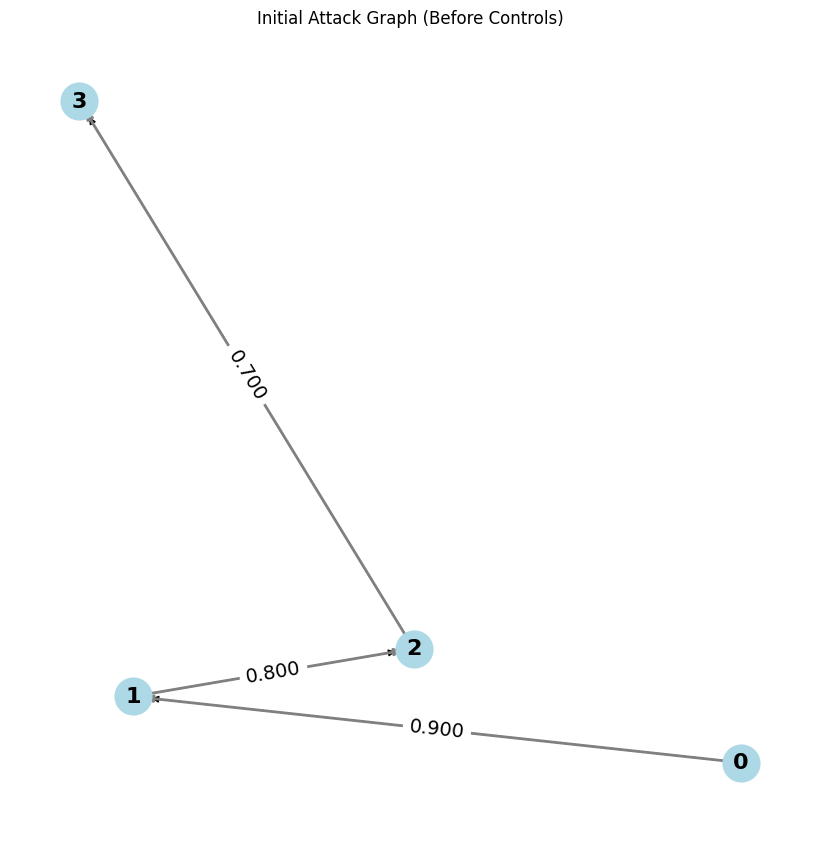

In [ ]:
visualize_graph(pi_e, [], "Initial Attack Graph (Before Controls)")

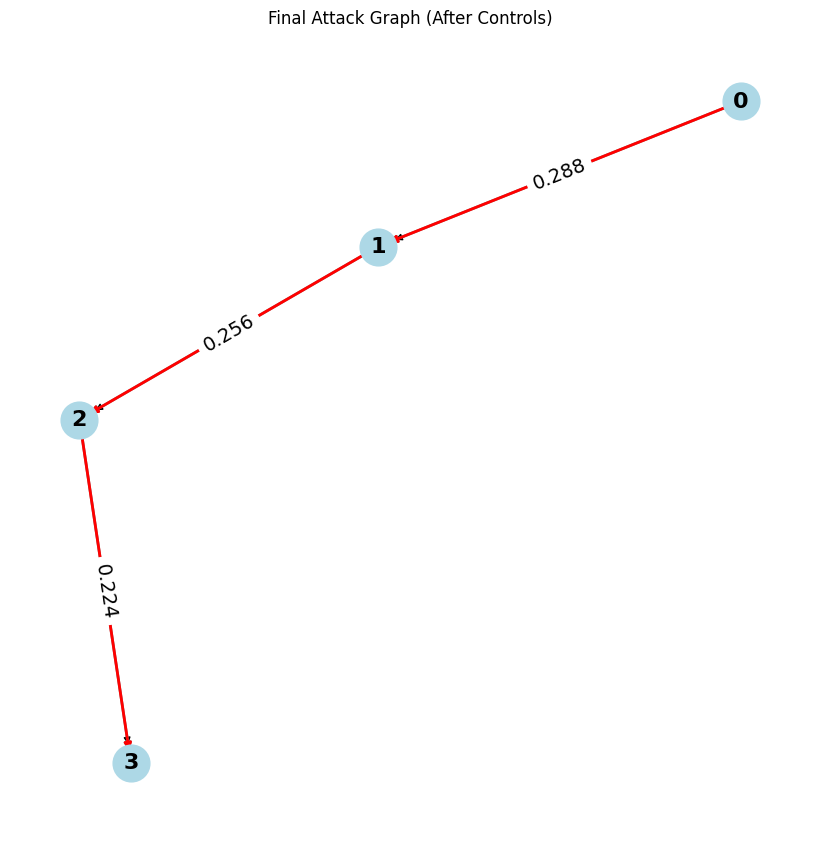

In [ ]:
visualize_graph(p_e_final, selected_edges, "Final Attack Graph (After Controls)")

## Example 2 `complex`

### Define the Complex Attack Graph

In [ ]:
# Define the attack graph using NetworkX
G = nx.DiGraph()

# Complex graph: nodes and edges
nodes = list(range(10))  # Nodes 0 to 9
edges = [(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 7), (7, 8), (8, 9)]  # Example edges

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)


### Define Control Parameters and Costs

In [ ]:
# Define control parameters and costs
control_levels = {
    'control_1': [0.9, 0.6, 0.3],
    'control_2': [0.85, 0.5],
    'control_3': [0.75, 0.4, 0.2],
    'control_4': [0.7, 0.3]
}
costs = {
    'control_1': [1500, 2500, 3500],
    'control_2': [1200, 2000],
    'control_3': [1000, 1800, 2600],
    'control_4': [900, 1600]
}
indirect_costs = {
    'control_1': [200, 300, 400],
    'control_2': [150, 250],
    'control_3': [100, 180, 250],
    'control_4': [80, 140]
}

# Success probabilities for edges
p_e = {
    (0, 1): 0.95, (0, 2): 0.9, (1, 3): 0.85, (2, 3): 0.8, (2, 4): 0.75,
    (3, 5): 0.7, (4, 6): 0.65, (5, 7): 0.6, (6, 7): 0.55, (7, 8): 0.5,
    (8, 9): 0.45
}
# p_e = {
#     (0, 1): 1, (0, 2): 1, (1, 3): 1, (2, 3): 1, (2, 4): 1,
#     (3, 5): 1, (4, 6): 1, (5, 7): 1, (6, 7): 1, (7, 8): 1,
#     (8, 9): 1
# }

# Baseline probabilities (without controls)
pi_e = p_e.copy()


### Define Budgets

In [ ]:
# Define budgets
B_D = 10000
B_I = 1000

### Define Variables

In [ ]:
# Define binary variables for control implementations
x = {c: cp.Variable(len(levels), boolean=True) for c, levels in control_levels.items()}

# Define binary variables for edges in the attack graph
y = {e: cp.Variable(boolean=True) for e in G.edges()}

# Define the dual variables for flow conservation
lambda_s = cp.Variable()
lambda_t = cp.Variable()

### Define the Obj Function and Constraints

In [ ]:
# Objective function: minimize the maximum success probability of an attack path
objective = cp.Minimize(lambda_t - lambda_s)

# Constraints
constraints = []

# Flow conservation constraints
for v in G.nodes():
    if v == 0:  # source node
        constraints.append(cp.sum([y[e] for e in G.out_edges(v)]) - cp.sum([y[e] for e in G.in_edges(v)]) == 1)
    elif v == 9:  # target node
        constraints.append(cp.sum([y[e] for e in G.out_edges(v)]) - cp.sum([y[e] for e in G.in_edges(v)]) == -1)
    else:  # intermediate nodes
        constraints.append(cp.sum([y[e] for e in G.out_edges(v)]) - cp.sum([y[e] for e in G.in_edges(v)]) == 0)

# Control implementation constraints
for c, levels in control_levels.items():
    constraints.append(cp.sum(x[c]) <= 1)  # Only one level of each control can be implemented

# Cost constraints
total_cost = cp.sum([cp.sum(cp.multiply(costs[c], x[c])) for c in costs])
total_indirect_cost = cp.sum([cp.sum(cp.multiply(indirect_costs[c], x[c])) for c in indirect_costs])
constraints.append(total_cost <= B_D)
constraints.append(total_indirect_cost <= B_I)

# Logarithmic constraints for success probabilities on edges
for e in G.edges():
    constraints.append(lambda_t - lambda_s >= cp.log(pi_e[e]) + cp.sum([x[c][l] * np.log(control_levels[c][l]) for c, levels in control_levels.items() for l in range(len(levels)) if e in G.edges()]))


### Solve the Optimization Problem

In [ ]:
# Solve the optimization problem
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.GUROBI)

# Represents the minimized expected damage or security risk.
print("Optimal value for :", result)

for c in control_levels:
    # Shows the implementation levels of security controls chosen by the optimizer to achieve the minimum risk.
    print(f"Control {c} levels:", x[c].value)
for e in G.edges():
    # Selected Edges: Indicates which edges (attack paths) are critical and thus part of the optimized solution to minimize risk.
    print(f"Edge {e} selected:", y[e].value)


Optimal value for : -4.231195744971298
Control control_1 levels: [0. 0. 1.]
Control control_2 levels: [1. 0.]
Control control_3 levels: [0. 0. 1.]
Control control_4 levels: [0. 1.]
Edge (0, 1) selected: 0.0
Edge (0, 2) selected: 1.0
Edge (1, 3) selected: 0.0
Edge (2, 3) selected: 0.0
Edge (2, 4) selected: 1.0
Edge (3, 5) selected: 0.0
Edge (4, 6) selected: 1.0
Edge (5, 7) selected: 0.0
Edge (6, 7) selected: 1.0
Edge (7, 8) selected: 1.0
Edge (8, 9) selected: 1.0


In [ ]:
# Apply the selected controls to update success probabilities
p_e_final = pi_e.copy()
for e in G.edges():
    for c, levels in control_levels.items():
        for l in range(len(levels)):
            if x[c][l].value > 0.5:
                p_e_final[e] *= control_levels[c][l]

# Print the updated success probabilities
print("Updated success probabilities after applying controls:")
for e in G.edges():
    print(f"Edge {e}: {p_e_final[e]}")

Updated success probabilities after applying controls:
Edge (0, 1): 0.014534999999999998
Edge (0, 2): 0.013770000000000001
Edge (1, 3): 0.013005
Edge (2, 3): 0.012240000000000001
Edge (2, 4): 0.011474999999999999
Edge (3, 5): 0.01071
Edge (4, 6): 0.009945
Edge (5, 7): 0.00918
Edge (6, 7): 0.008415
Edge (7, 8): 0.0076500000000000005
Edge (8, 9): 0.0068850000000000005


### Visualize the Results

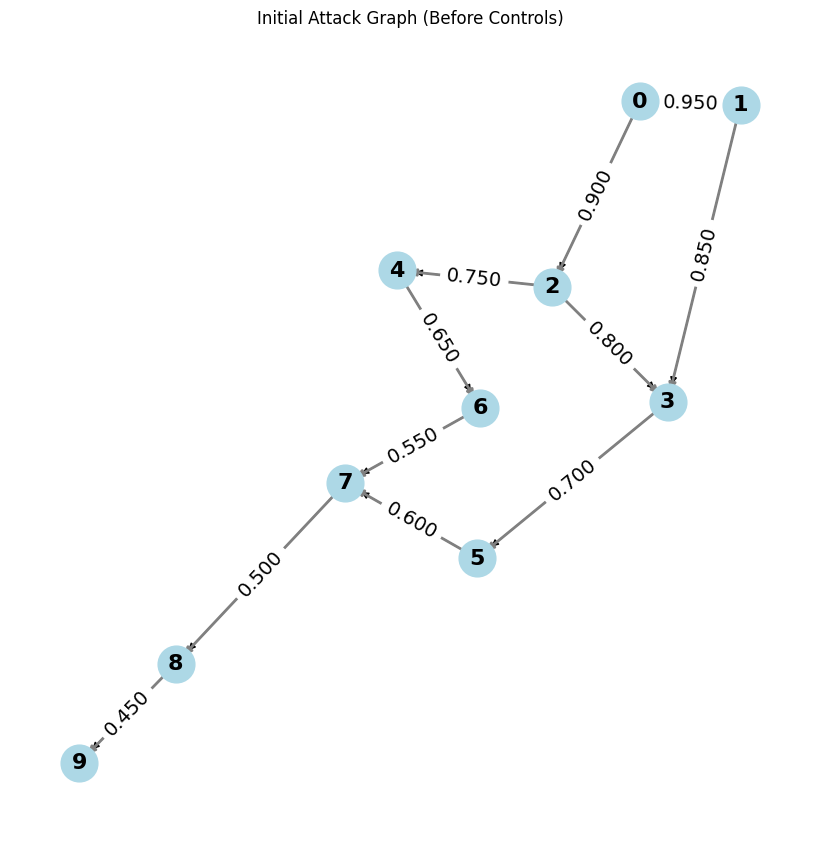

In [ ]:
visualize_graph(pi_e, [], "Initial Attack Graph (Before Controls)")

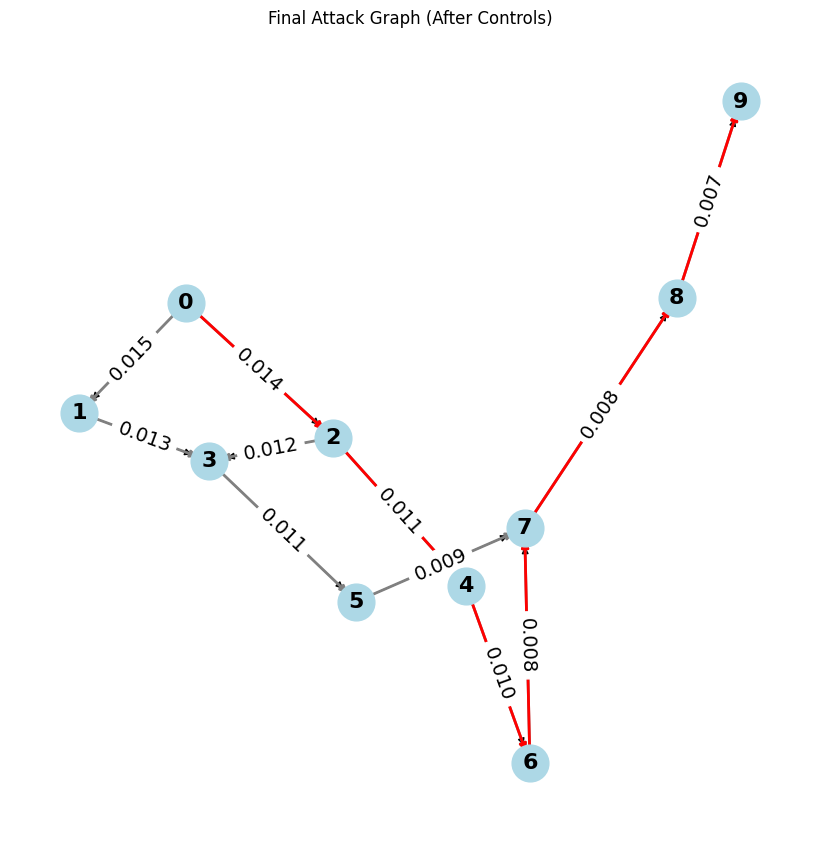

In [ ]:
visualize_graph(p_e_final, selected_edges, "Final Attack Graph (After Controls)")

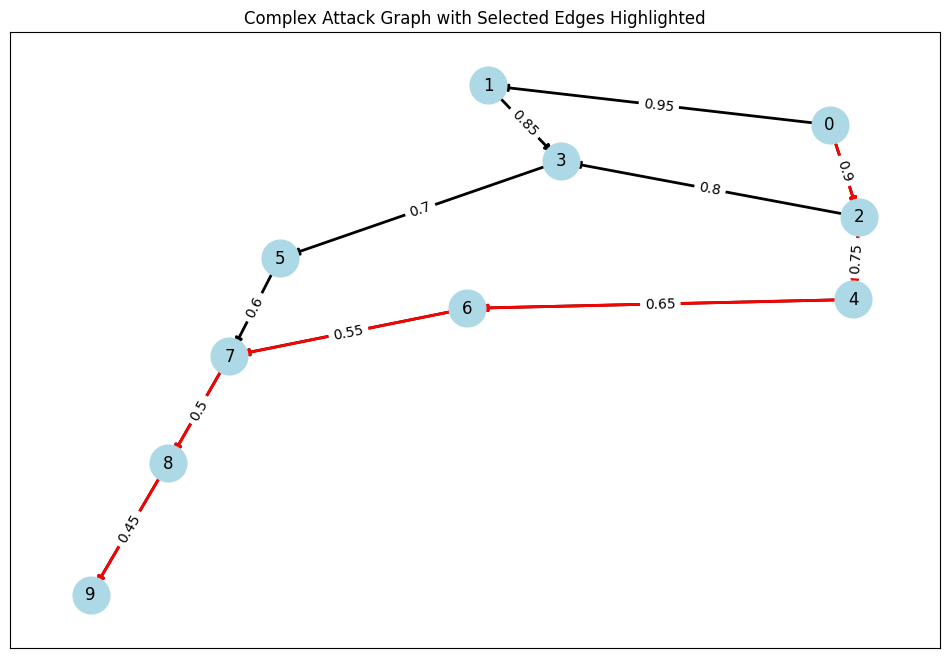

In [ ]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2)

# Highlight selected edges in red
selected_edges = [e for e in G.edges() if y[e].value > 0.5]
nx.draw_networkx_edges(G, pos, edgelist=selected_edges, width=2, edge_color='r')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
labels = {e: f'{p_e[e]}' for e in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("Complex Attack Graph with Selected Edges Highlighted")
plt.show()

In [ ]:
# Parameters
"""
pe = {e: 0.7 for e in E}                            # Probability of success for each edge
s = N[0]                                            # Source
t = N[-1]                                           # Target


cost_value = []
indirect_cost_value = []
Cost = {(c, l): cost_value for c in C for l in L}
IndirectCost = {(c, l): indirect_cost_value for c in C for l in L}
"""

In [ ]:
# Variables
#x = cvx.Variable()                                  # Security Plan
lambda_s = cp.Variable()
lambda_t = cp.Variable()
x = cp.Variable((len(C), len(L)))     # Control selection variables

NameError: name 'C' is not defined

In [ ]:
# Objective function
objective = cp.Minimize(lambda_s - lambda_t)

In [ ]:
# Constraints
constraints = []

# Cost and indirect cost constraints

In [ ]:
# Solution
prob = cp.Problem(objective, constraints)
prob.solve()

In [ ]:
!pip install cvxpy numpy networkx

In [ ]:
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 28.5 MB/s eta 0:00:00


In [ ]:
import cvxpy as cp
import numpy as np
import networkx as nx

# Define the attack graph using NetworkX
G = nx.DiGraph()

# Example graph: nodes and edges
nodes = [0, 1, 2, 3]  # Example nodes
edges = [(0, 1), (1, 2), (2, 3)]  # Example edges

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Define control parameters and costs
control_levels = {
    'control_1': [0.8, 0.5],
    'control_2': [0.7, 0.4]
}
costs = {
    'control_1': [1000, 2000],
    'control_2': [800, 1500]
}
indirect_costs = {
    'control_1': [100, 150],
    'control_2': [50, 70]
}

# Success probabilities for edges
p_e = {
    (0, 1): 0.9,
    (1, 2): 0.8,
    (2, 3): 0.7
}

# Baseline probabilities (without controls)
pi_e = {
    (0, 1): 0.9,
    (1, 2): 0.8,
    (2, 3): 0.7
}

# Define budgets
B_D = 3000
B_I = 200


In [ ]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


In [ ]:
# Define binary variables for control implementations
x = {c: cp.Variable(len(levels), boolean=True) for c, levels in control_levels.items()}

# Define binary variables for edges in the attack graph
y = {e: cp.Variable(boolean=True) for e in G.edges()}

# Define the dual variables for flow conservation
lambda_s = cp.Variable()
lambda_t = cp.Variable()

# Objective function: minimize the maximum success probability of an attack path
objective = cp.Minimize(lambda_t - lambda_s + sum(cp.sum(cp.multiply(np.log(control_levels[c]), x[c])) for c in control_levels))

# Constraints
constraints = []

# Flow conservation constraints
for v in G.nodes():
    if v == 0:  # source node
        constraints.append(cp.sum([y[e] for e in G.out_edges(v)]) - cp.sum([y[e] for e in G.in_edges(v)]) == 1)
    elif v == 3:  # target node
        constraints.append(cp.sum([y[e] for e in G.out_edges(v)]) - cp.sum([y[e] for e in G.in_edges(v)]) == -1)
    else:  # intermediate nodes
        constraints.append(cp.sum([y[e] for e in G.out_edges(v)]) - cp.sum([y[e] for e in G.in_edges(v)]) == 0)

# Control implementation constraints
for c, levels in control_levels.items():
    constraints.append(cp.sum(x[c]) <= 1)  # Only one level of each control can be implemented

# Cost constraints
total_cost = cp.sum([cp.sum(cp.multiply(costs[c], x[c])) for c in costs])
total_indirect_cost = cp.sum([cp.sum(cp.multiply(indirect_costs[c], x[c])) for c in indirect_costs])
constraints.append(total_cost <= B_D)
constraints.append(total_indirect_cost <= B_I)

# Logarithmic constraints for success probabilities on edges
for e in G.edges():
    constraints.append(lambda_t - lambda_s >= cp.log(pi_e[e]) + cp.sum([x[c][l] * np.log(control_levels[c][l]) for c, levels in control_levels.items() for l in range(len(levels)) if e in G.edges()]))

# Solve the optimization problem
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.GUROBI)

# Print the results
print("Optimal value:", result)
for c in control_levels:
    print(f"Control {c} levels:", x[c].value)
for e in G.edges():
    print(f"Edge {e} selected:", y[e].value)


SolverError: The solver GUROBI is not installed.

In [ ]:
# Define binary variables for control implementations
x = {c: cp.Variable(len(levels), boolean=True) for c, levels in control_levels.items()}

# Define binary variables for edges in the attack graph
y = {e: cp.Variable(boolean=True) for e in G.edges()}

# Define the dual variables for flow conservation
lambda_s = cp.Variable()
lambda_t = cp.Variable()

# Objective function: minimize the maximum success probability of an attack path
objective = cp.Minimize(lambda_t - lambda_s + sum(cp.sum(cp.multiply(np.log(control_levels[c]), x[c])) for c in control_levels))

# Constraints
constraints = []

# Flow conservation constraints
for v in G.nodes():
    if v == 0:  # source node
        constraints.append(cp.sum([y[e] for e in G.out_edges(v)]) - cp.sum([y[e] for e in G.in_edges(v)]) == 1)
    elif v == 3:  # target node
        constraints.append(cp.sum([y[e] for e in G.out_edges(v)]) - cp.sum([y[e] for e in G.in_edges(v)]) == -1)
    else:  # intermediate nodes
        constraints.append(cp.sum([y[e] for e in G.out_edges(v)]) - cp.sum([y[e] for e in G.in_edges(v)]) == 0)

# Control implementation constraints
for c, levels in control_levels.items():
    constraints.append(cp.sum(x[c]) <= 1)  # Only one level of each control can be implemented

# Cost constraints
total_cost = cp.sum([cp.sum(cp.multiply(costs[c], x[c])) for c in costs])
total_indirect_cost = cp.sum([cp.sum(cp.multiply(indirect_costs[c], x[c])) for c in indirect_costs])
constraints.append(total_cost <= B_D)
constraints.append(total_indirect_cost <= B_I)

# Logarithmic constraints for success probabilities on edges
for e in G.edges():
    constraints.append(lambda_t - lambda_s >= cp.log(pi_e[e]) + cp.sum([x[c][l] * np.log(control_levels[c][l]) for c, levels in control_levels.items() for l in range(len(levels)) if e in G.edges()]))

# Solve the optimization problem
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.GUROBI)

# Print the results
print("Optimal value:", result)
for c in control_levels:
    print(f"Control {c} levels:", x[c].value)
for e in G.edges():
    print(f"Edge {e} selected:", y[e].value)


SolverError: The solver GUROBI is not installed.